In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, sum as spark_sum, mean as spark_mean, when, isnull, explode

In [2]:
# Crear una sesión de Spark
spark = SparkSession.builder \
    .appName("AnalisisMongo") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/Metadata.Transcription") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/Metadata.Transcription") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
24/06/18 22:30:36 WARN Utils: Your hostname, esquezada resolves to a loopback address: 127.0.1.1; using 172.23.56.33 instead (on interface eth0)
24/06/18 22:30:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/esquezada/.ivy2/cache
The jars for the packages stored in: /home/esquezada/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-409433eb-4fc1-4829-8936-03deb80164dc;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
downloading https://repo1.maven.org/maven2/org/mongodb/spark/mongo-spark-connector_2.12/3.0.1/mongo-spark-connector_2.12-3.0.1.jar ...
	[SUCCESSFUL ] org.mongodb.spark#mongo-spark-connector_2.12;3.0.1!mongo-spark-connector_2.12.jar (445ms)
downloading https://repo1.maven.org/maven2/org/mongodb/mongodb-driver-sync/4.0.5/mongodb-driver-sync-4.0.5.jar ...
	[SUCCESSFUL ] org.mongodb#mongodb-driver-sync;4.0.5!mongodb-driver-sync.jar (168ms)
downloading https://repo1.ma

In [3]:
# Leer los documentos de MongoDB como un DataFrame de Spark
df = spark.read.format("mongo").load()

df.show()

+--------+--------------------+----------+--------------------+------------+--------------------+--------------------+
|Duration|              FileId|  FileName|          FolderName|      SizeMb|       Transcription|                 _id|
+--------+--------------------+----------+--------------------+------------+--------------------+--------------------+
|   600.0|f7245c98-7658-467...|121117.mp4|Razonamiento y pl...| 23.73046875|[{0, 539f383e-cf9...|{667224a5ece458c3...|
|   600.0|5eb6742f-7950-41f...|105977.mp4|Razonamiento y pl...| 23.73046875|[{0, 45e745e3-848...|{667224ceece458c3...|
|   600.0|826ef410-4982-4f7...|111109.mp4|Razonamiento y pl...| 23.73046875|[{0, 26187d95-c60...|{667224faece458c3...|
|   600.0|f0d3939a-fbba-40c...|118810.mp4|Razonamiento y pl...| 23.73046875|[{0, 1db81e1d-34b...|{6672252cece458c3...|
|   600.0|33137a90-3605-453...| 91435.mp4|Razonamiento y pl...|5.9326171875|[{0, 22532e7f-984...|{6672255aece458c3...|
|   600.0|f3c9d5d6-e6ab-4c5...|103781.mp4|Razona

>EDA

In [4]:
# Contar el número de registros
print(f"Total number of records: {df.count()}")

Total number of records: 155


In [5]:
# Mostrar una muestra de los datos
df.select("FileName", "Duration", "SizeMb").show(5)

+----------+--------+------------+
|  FileName|Duration|      SizeMb|
+----------+--------+------------+
|121117.mp4|   600.0| 23.73046875|
|105977.mp4|   600.0| 23.73046875|
|111109.mp4|   600.0| 23.73046875|
|118810.mp4|   600.0| 23.73046875|
| 91435.mp4|   600.0|5.9326171875|
+----------+--------+------------+
only showing top 5 rows



In [6]:
#Agrupar por FolderName (Nombre de la materia) y contar el número de videos
df.groupBy("FolderName").count().show()

+--------------------+-----+
|          FolderName|count|
+--------------------+-----+
|Razonamiento y pl...|   21|
|Trabajo Fin de Má...|    4|
|Análisis e Interp...|   19|
|Gobierno del Dato...|   13|
|Herramientas de V...|   13|
|Técnicas de Intel...|   17|
|Ingeniería para e...|   16|
|Visualización Int...|   16|
|Bases de Datos pa...|   17|
|Sistemas Cognitiv...|   19|
+--------------------+-----+



In [7]:
# Obtener estadísticas descriptivas de las duraciones de los archivos
df.select("Duration").describe().show()

+-------+------------------+
|summary|          Duration|
+-------+------------------+
|  count|               155|
|   mean|1257.6103225806453|
| stddev|1349.8322247864633|
|    min|            257.68|
|    max|           6054.16|
+-------+------------------+



In [18]:
# Análisis de la transcripción
exploded_df = df.select("FileId", "FileName", "FolderName", "Duration", explode("Transcription").alias("Transcription"))
transcription_df = exploded_df.select("FileId", "FileName", "FolderName", "Duration", 
                                      "Transcription.StartTime", 
                                      "Transcription.EndTime", 
                                      "Transcription.Text")

# Mostrar algunas transcripciones
transcription_df.show(5)

+--------------------+----------+--------------------+--------+------------------+------------------+--------------------+
|              FileId|  FileName|          FolderName|Duration|         StartTime|           EndTime|                Text|
+--------------------+----------+--------------------+--------+------------------+------------------+--------------------+
|f7245c98-7658-467...|121117.mp4|Razonamiento y pl...|   600.0|               0.0|               7.0| Bueno, bueno, pu...|
|f7245c98-7658-467...|121117.mp4|Razonamiento y pl...|   600.0|               7.0|              9.56| Si no recordo, e...|
|f7245c98-7658-467...|121117.mp4|Razonamiento y pl...|   600.0|              9.56|              13.6| Nos tengo una se...|
|f7245c98-7658-467...|121117.mp4|Razonamiento y pl...|   600.0|              13.6|19.400000000000002| Bienvenidos a lo...|
|f7245c98-7658-467...|121117.mp4|Razonamiento y pl...|   600.0|19.400000000000002|             22.28| pero que también...|
+---------------

In [19]:
# Eliminar registros vacíos en el campo Text
transcription_df_cleaned = transcription_df.filter(~(isnull("Text") | (col("Text") == "")))
print(transcription_df.count(), transcription_df_cleaned.count())

26831 26831


> Generación de variables calculadas

In [20]:


# Calcular los segundos de cada transcripción
transcription_df_cleaned = transcription_df_cleaned.withColumn("DurationSegment", col("EndTime") - col("StartTime"))

# Calcular el tiempo total de las transcripciones por FileId
transcription_time_df = transcription_df_cleaned.groupBy("FileId").agg(spark_sum("DurationSegment").alias("TotalTranscriptionTime"))

# Unir con el DataFrame original para obtener la duración total del video
silence_df = transcription_time_df.join(df.select("FileId", "FileName", "FolderName","Duration"), on="FileId")

# Calcular el tiempo de silencio
silence_df = silence_df.withColumn("SilenceTime", col("Duration") - col("TotalTranscriptionTime"))

# Mostrar los resultados
silence_df.select("FileId", "FileName", "FolderName", "Duration", "TotalTranscriptionTime", "SilenceTime").show()


+--------------------+----------+--------------------+--------+----------------------+------------------+
|              FileId|  FileName|          FolderName|Duration|TotalTranscriptionTime|       SilenceTime|
+--------------------+----------+--------------------+--------+----------------------+------------------+
|99bb6104-00ce-426...|113518.mp4|Ingeniería para e...|   600.0|                596.04|3.9600000000000364|
|dd877363-aa9d-426...|104666.mp4|Bases de Datos pa...|   600.0|     595.7199999999998|   4.2800000000002|
|ccd3ee3f-22e4-48f...| 85987.mp4|Razonamiento y pl...|   600.0|     593.6800000000001| 6.319999999999936|
|2b53621f-9533-453...|137933.mp4|Herramientas de V...| 3458.56|     563.9999999999999|           2894.56|
|345f0288-6c5a-4e1...|123094.mp4|Razonamiento y pl...|   600.0|     586.5799999999998|13.420000000000186|
|49b90670-b76e-4dc...|113951.mp4|Análisis e Interp...|   600.0|                598.76| 1.240000000000009|
|f7245c98-7658-467...|121117.mp4|Razonamiento 

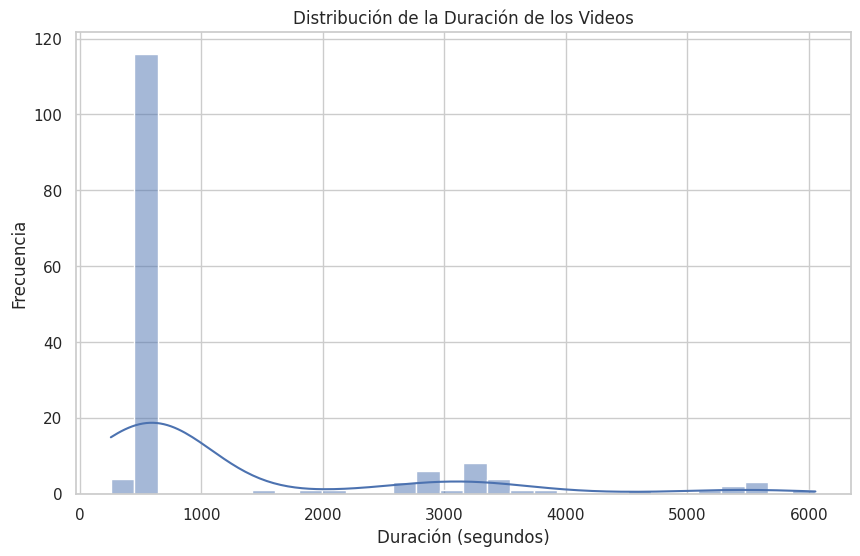

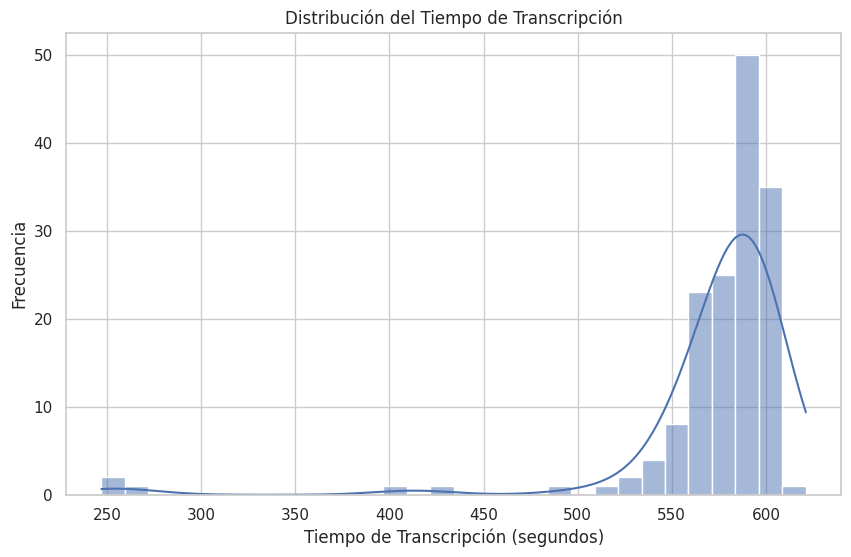

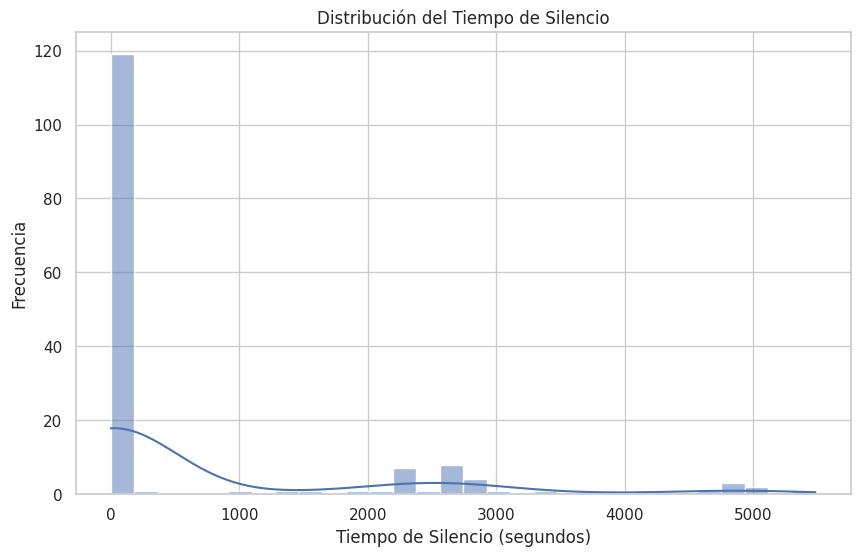

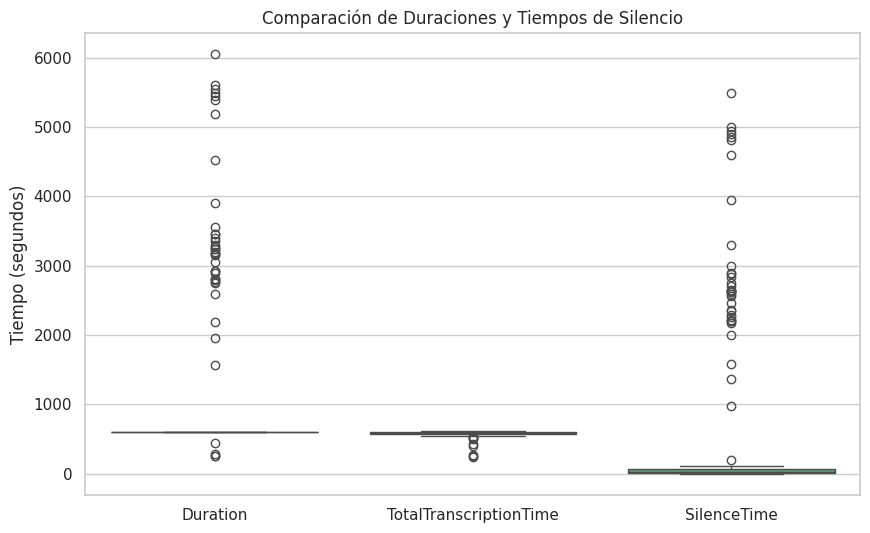

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convertir a Pandas DataFrame
silence_pd_df = silence_df.select("FileId", "Duration", "TotalTranscriptionTime", "SilenceTime").toPandas()

# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Distribución de la Duración de los Videos
plt.figure(figsize=(10, 6))
sns.histplot(silence_pd_df['Duration'], bins=30, kde=True)
plt.title('Distribución de la Duración de los Videos')
plt.xlabel('Duración (segundos)')
plt.ylabel('Frecuencia')
plt.show()

# Distribución del Tiempo de Transcripción
plt.figure(figsize=(10, 6))
sns.histplot(silence_pd_df['TotalTranscriptionTime'], bins=30, kde=True)
plt.title('Distribución del Tiempo de Transcripción')
plt.xlabel('Tiempo de Transcripción (segundos)')
plt.ylabel('Frecuencia')
plt.show()

# Distribución del Tiempo de Silencio
plt.figure(figsize=(10, 6))
sns.histplot(silence_pd_df['SilenceTime'], bins=30, kde=True)
plt.title('Distribución del Tiempo de Silencio')
plt.xlabel('Tiempo de Silencio (segundos)')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot para Comparar Duraciones y Tiempos de Silencio
plt.figure(figsize=(10, 6))
sns.boxplot(data=silence_pd_df[['Duration', 'TotalTranscriptionTime', 'SilenceTime']])
plt.title('Comparación de Duraciones y Tiempos de Silencio')
plt.ylabel('Tiempo (segundos)')
plt.show()


In [22]:
# Calcular la media de silencios por FolderName
mean_silence_by_folder = silence_df.groupBy("FolderName").agg(spark_mean("SilenceTime").alias("MeanSilenceTime"))

# Mostrar los resultados
mean_silence_by_folder.show()

+--------------------+------------------+
|          FolderName|   MeanSilenceTime|
+--------------------+------------------+
|Razonamiento y pl...|15.025714285714272|
|Trabajo Fin de Má...| 28.11999999999992|
|Análisis e Interp...| 36.96736842105264|
|Gobierno del Dato...|21.712307692307604|
|Herramientas de V...|2508.2415384615388|
|Técnicas de Intel...|3624.8176470588232|
|Ingeniería para e...| 8.780000000000015|
|Visualización Int...|14.065000000000012|
|Bases de Datos pa...|28.067058823529372|
|Sistemas Cognitiv...| 505.1326315789474|
+--------------------+------------------+



/tmp/ipykernel_652914/3701077738.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_silence_pd_df, x="FolderName", y="MeanSilenceTime", palette="viridis")


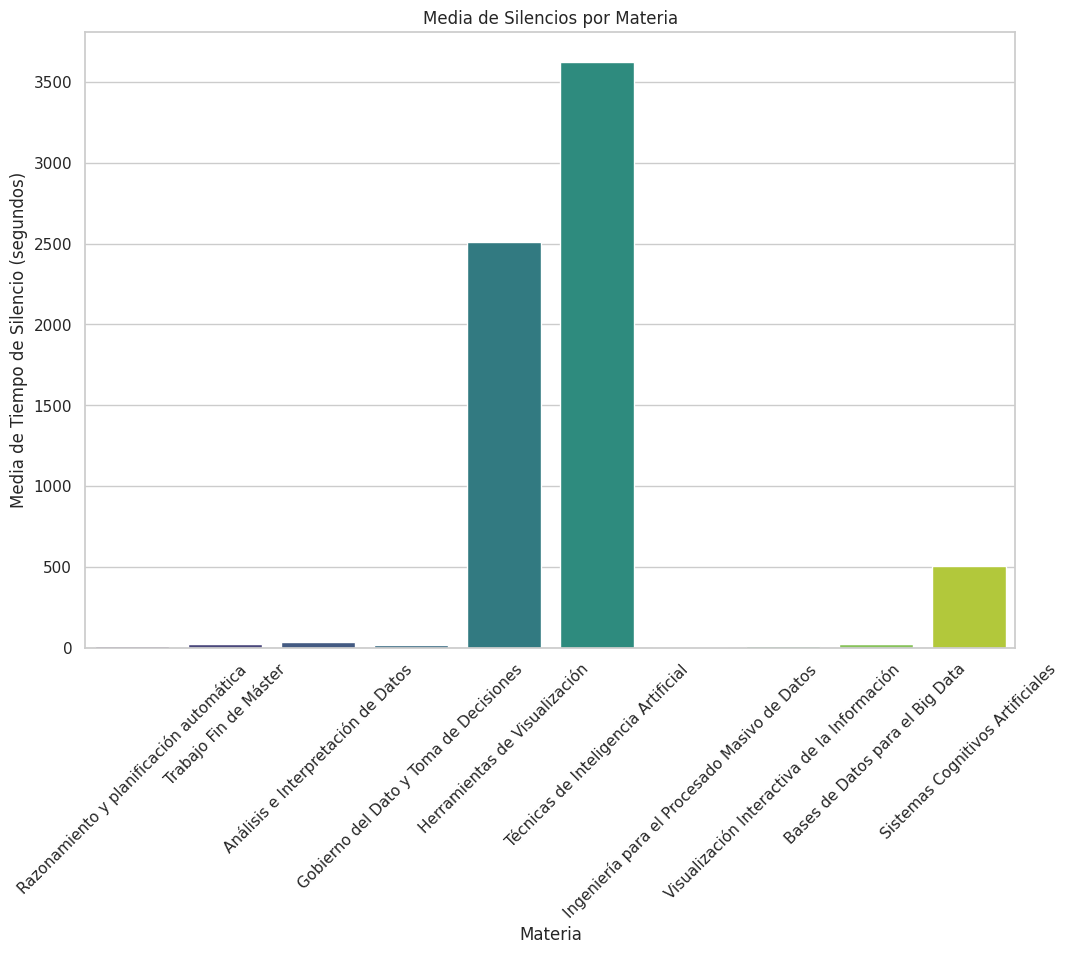

In [23]:
# Convertir a Pandas DataFrame
mean_silence_pd_df = mean_silence_by_folder.toPandas()

# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Visualización de la Media de Silencios por FolderName
plt.figure(figsize=(12, 8))
sns.barplot(data=mean_silence_pd_df, x="FolderName", y="MeanSilenceTime", palette="viridis")
plt.title('Media de Silencios por Materia')
plt.xlabel('Materia')
plt.ylabel('Media de Tiempo de Silencio (segundos)')
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import Tokenizer, StopWordsCleaner

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, split, regexp_replace, lower, count
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import Tokenizer, StopWordsCleaner
from pyspark.sql import functions as F

# Crear una sesión de Spark
spark = SparkSession.builder \
    .appName("MongoDBIntegration") \
    .config("spark.mongodb.input.uri", "mongodb://<user>:<password>@<host>:<port>/Metadata.Transcription") \
    .config("spark.mongodb.output.uri", "mongodb://<user>:<password>@<host>:<port>/Metadata.Transcription") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1,com.johnsnowlabs.nlp:spark-nlp_2.12:3.1.3") \
    .getOrCreate()

# Leer la colección de MongoDB
df = spark.read.format("mongo").load()

# Explode la columna Transcription para trabajar con ella
exploded_df = df.select("FileId", "FileName", "FolderName", "Duration", explode("Transcription").alias("Transcription"))

# Seleccionar columnas de la transcripción
transcription_df = exploded_df.select("FileId", "FileName", "FolderName", "Duration", 
                                      "Transcription.StartTime", 
                                      "Transcription.EndTime", 
                                      "Transcription.Text")

# Eliminar registros vacíos en el campo Text
transcription_df_cleaned = transcription_df.filter(~(isnull("Text") | (col("Text") == "")))

# Convertir el texto a minúsculas y eliminar caracteres especiales
transcription_df_cleaned = transcription_df_cleaned.withColumn("CleanText", lower(regexp_replace(col("Text"), "[^a-zA-Z0-9\s]", "")))

# Configurar el DocumentAssembler
document_assembler = DocumentAssembler() \
    .setInputCol("CleanText") \
    .setOutputCol("document")

# Configurar el Tokenizer
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# Configurar el StopWordsCleaner
stopwords_cleaner = StopWordsCleaner() \
    .setInputCols(["token"]) \
    .setOutputCol("cleanTokens") \
    .setCaseSensitive(False)

# Configurar el Finisher
finisher = Finisher() \
    .setInputCols(["cleanTokens"]) \
    .setOutputCols(["finishedTokens"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(False)

# Crear el pipeline de NLP
nlp_pipeline = Pipeline(stages=[
    document_assembler, 
    tokenizer, 
    stopwords_cleaner, 
    finisher
])

# Ajustar y transformar los datos
nlp_model = nlp_pipeline.fit(transcription_df_cleaned)
cleaned_df = nlp_model.transform(transcription_df_cleaned)

# Explode los tokens limpios y contar la frecuencia de cada palabra por FileId
words_df = cleaned_df.withColumn("word", explode(col("finishedTokens")))

# Contar las palabras por FileId
word_count_df = words_df.groupBy("FileId", "word").count().withColumnRenamed("count", "word_count")

# Mostrar el resultado
word_count_df.show(truncate=False)

# Detener la sesión de Spark
spark.stop()


In [ ]:
# Detener la sesión de Spark
spark.stop()